In [31]:
# import sys
# !{sys.executable} -m pip install python-igraph simpy numpy scipy matplotlib

     |████████████████████████████████| 12.4 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 1.5 MB/s eta 0:00:01
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [33]:
import igraph
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng, RandomState
from scipy.stats import fisk # log-logistic distribution
from simpy import *
from simpy.events import AnyOf, AllOf, Event
from simpy.resources.store import *

In [85]:
%matplotlib

Using matplotlib backend: MacOSX


# Configuration

In [534]:
MEAN_BLOCK_TIME = 30
EPOCH = 120

# block latencies (validation + network + validation, including pact validation)
LOCAL_BLOCK_LATENCY = 0.2
REMOTE_BLOCK_LATENCY = 1
NUMBER_OF_MINING_NODES = 2

# Median delay of pact new block calls delay
PACT_NEW_BLOCK_TIME = 0.1

# Seed for the PRNG
RNG_SEED = 17

# Preliminaries

## Random Number Generator

In [458]:
prng = default_rng(RNG_SEED)
prng_ = RandomState(RNG_SEED) # scipy uses the legacy generator

## Graphs

Chainweb graphs are undirected and regular graphs that are choosen to have low degree and low diameter. 

Each vertex of a Chainweb graph represents a chain and edges designate the dependencies between blocks on different chains. A block on chain $c$ at height $h$ has to reference each block of height $h-1$ on all chains that are adjacent to $c$. In addition a block at height $h$ also depends on the block at height $h-1$ on the same chain. We also say that a chain $c$ depends on a chan $d$ if $c$ is adjacent to $d$.

Since Chainweb graphs are undirected, dependencies between chains are symmetric. Thus, In the following we encode dependencies using directed, symmetric directed graphs. We also make them reflexiv, by making each vertex adjacent to itself, because each each block depends on its parent on the same chain.

The $\text{Peterson}$ graph is of minimal order (number of vertices) for degree 3 and diameter 2. 

In [459]:
def peterson():
    graph = igraph.Graph(directed=True)
    graph.add_vertices(10)
    graph.add_edges(
        [ (0, 0), (0, 2), (0, 3), (0, 5)
        , (1, 1), (1, 3), (1, 4), (1, 6)
        , (2, 2), (2, 0), (2, 4), (2, 7)
        , (3, 3), (3, 0), (3, 1), (3, 8)
        , (4, 4), (4, 1), (4, 2), (4, 9)
        , (5, 5), (5, 0), (5, 6), (5, 9)
        , (6, 6), (6, 1), (6, 5), (6, 7)
        , (7, 7), (7, 2), (7, 6), (7, 8)
        , (8, 8), (8, 3), (8, 7), (8, 9)
        , (9, 9), (9, 4), (9, 5), (9, 8)
        ]
    )
    return(graph)

Peterson = peterson()

The $\text{Twenty}$ chain graph is of minimal order for degree 3 and diameter 3.

In [460]:

def twenty():
    graph = igraph.Graph(directed=True)
    graph.add_vertices(20)
    graph.add_edges(
        [ (0, 0), (0, 10), (0,15), (0,5)
        , (1, 1), (1, 11), (1,16), (1,6)
        , (2, 2), (2, 12), (2,17), (2,7)
        , (3, 3), (3, 13), (3,18), (3,8)
        , (4, 4), (4, 14), (4,19), (4,9)
        , (5, 5), (5, 0), (5,7), (5,8)
        , (6, 6), (6, 1), (6,8), (6,9)
        , (7, 7), (7, 2), (7,5), (7,9)
        , (8, 8), (8, 3), (8,5), (8,6)
        , (9, 9), (9, 4), (9,6), (9,7)
        , (10, 10), (10, 0), (10,11), (10,19)
        , (11, 11), (11, 1), (11,10), (11,12)
        , (12, 12), (12, 11), (12,13), (12,2)
        , (13, 13), (13, 12), (13,14), (13,3)
        , (14, 14), (14, 13), (14,15), (14,4)
        , (15, 15), (15, 0), (15,14), (15,16)
        , (16, 16), (16, 1), (16,15), (16,17)
        , (17, 17), (17, 16), (17,18), (17,2)
        , (18, 18), (18, 17), (18,19), (18,3)
        , (19, 19), (19, 10), (19,18), (19,4)
        ]
    )
    return (graph)

Twenty = twenty()

## Histogram

Quick and Dirty Linear Histograms.

In [461]:
# TODO: there are probably some good libraries with support for this
#
class Histogram:

    def __init__(self, binSize):
        self.bins = {}
        self.binSize = binSize

    def sample(self, x):
        i = math.floor(x / self.binSize)
        if i in self.bins:
            self.bins[i] += 1
        else:
            self.bins[i] = 1

    def append(self, h):
        if h.binSize == self.binSize:
            for i in h.bins:
                if i in self.bins:
                    self.bins[i] += h.bins[i]
                else:
                    self.bins[i] = h.bins[i]
        else:
            throw("merging histograms with different bin sizes isn't yet implemented")

    def result(self):
        imin = min(self.bins.keys())
        imax = max(self.bins.keys())
        a = [0] * (imax - imin + 1)
        b = [self.binSize * k for k in range(imin, imax + 1)]
        for i in range(imin, imax + 1):
            if i in self.bins:
                a[i - imin] = self.bins[i]
        return a, b

# TODO: implement more general WithStatistics class
class HistogramSample:
    def __init__(self, histogram, clock):
        self.histogram = histogram
        self.clock = clock
    def __enter__(self):
        self.start = self.clock.now
        return self.start
    def __exit__(self, type, value, traceback):
        self.histogram.sample(self.clock.now - self.start)
        return None # rethrow

## Logger

In [462]:
# Each object must have a method called "label"
class Logger:
    def __init__(self, env, label : str, tags : [str] = []):
        self.label = label
        self.tags = tags
        self.env = env
    
    def logg(self, tag : str, msg : str):
        if tag in self.tags:
            print("[%d][%s] %s" % (self.env.now, self.label, msg))

# Simulation Model

The goal of the simulation is to investigate the interaction of dependencies between chains and difficulty adjustement in the computation of a single chain. 

Block production (*mining*) on each chain is exponentially distributed.
The mean mining time is called the $\text{target}$. Mining on a chain can only proceed if all dependencies are available. I.e. a block on chain $c$ at height $h$ can be mined only after all blocks at height $h-1$ have been mined on $c$ and all chains adjacent to $c$. We say that a chain is *blocked* when it is done mining a block and while it is waiting for dependencies for the next block to become available. The overall *block time* is the time that it takes a chain to do a full cycle from starting to mine a block to starting to mine the next block, i.e. the time that mining takes, plus the time it is blocked, plus any potential additional latencies. 

POW blockchain algorithms are desigined such that the overall block time resembles an exponential distriution with a particular mean. The goal of *Difficulty Adjustment* is to adjust the target such that the observed mean matches the targeted mean. Single chain POW block chains can't be blocked and block times are exponentially distributed when the mining time dominates the other latencies. This can be achieved by choosing the a block time that is sufficiently large compared to network propgation and validation times. (For the purpose of this research, we are ignoring races that result in orphans.) In Chainweb chains can additionally be blocked and the distribution of the block time results from the the combination of the mining distribution, the distribution of times that chains are blocked, and the distribution of other latencies (network propagation and block validation).

The model is designed to investigate how the choice of the difficulty adjustment algorithm affect the overall resulting block time distribution in Chainweb.

We don't model consensus. Therefore the model doesn't include races between distributed nodes and orphan blocks. Because there are no conflicts only a single block for each chain and height is produced. Thus, blocks are uniquly identified by their chain and height. Also, each block is used exactly once by each adjacent chain. In other words a single linear chainweb is produced without any forks. 

Each vertex in the graph is labeled with a `Chain`, which is implemented as a `Process` that mines blocks on that chain. 

Dependencies between chain processes are implemented by passing messages with new blocks to adjacent chains. A chain can only produce a new block if all of its dependencies have been received. Each (directed) edge is assigned a communication channel. The source chain of an edge publishes new blocks to the channel. The target of the edge can receive a block ar specific height by awaiting that block on the channel.

## Durations

We use the generic term $\text{latency}$ to summarize the duration of the validation of a block after it is discovered and before it is published, the network latency, and the validation after it is received. In case a block is discovered on the same node the network latency and one validation step are omitted. This is modeled by using a Bernoulli distribution to estimate the chance that a block is mined locally and a reduced latency is used.

Pact new block validation is modeled separately because, depending on the mining framework that is used, it is applied after a chain becomes unblocked.

In [542]:
def gamma5(mean):
    return prng.gamma(shape=5, scale=mean/5)

# latency: validation + network + validation
def latencyDelay():
    is_local = prng.binomial(n=1, p = 1 / NUMBER_OF_MINING_NODES)
    if is_local:
        return gamma5(LOCAL_BLOCK_LATENCY)
    else:
        return gamma5(REMOTE_BLOCK_LATENCY)

# Pact new block
def pactDelay():
    return gamma5(PACT_NEW_BLOCK_TIME)

# Mining is exponentialy distributed with the target being the mean
def miningDelay(target):
    return prng.exponential(target)

## Blocks

In [543]:
class Block:
    def __init__(self, chainId, height, time, epochTime, target):
        self.chainId = chainId
        self.height = height
        self.time = time

        # For Da
        self.epochTime = epochTime
        self.target = target

        def __lt__(self, other):
            self.height < other.height

## Difficulty Adjustment Algorithms

In [544]:
# DA that does local adjustments based on a globally
# synchronized epoch.
#
# This is what is currently implemented on mainnet.
#
def chainDa(env, parent):
    if parent == None:
        return env.now, MEAN_BLOCK_TIME
    if (parent.height + 1) % EPOCH == 0:
        epochTime = parent.time
        target = parent.target * (MEAN_BLOCK_TIME * EPOCH) / (parent.time - parent.epochTime)
        # self.logg("da", "adjusted target from %f to %f" % (parent.target, target))
    else:
        epochTime = parent.epochTime
        target = parent.target
    return epochTime, target

# DA that is based on globally synchronized epoch. It performs
# chainDa and takes the average for the chain along with all it's
# adjacent chains.
#
def avgDa(env, parent, parents):
    def avg(a): return sum(a) / len(a)

    if parent == None:
        return env.now, MEAN_BLOCK_TIME
    epochTimes, targets = zip(*[self.chainDa(p) for p in list(parents).append(parent)])
    epochTime = avg(epochTimes)
    target = avg(targets)
    self.logg("da", "adjusted target from %f to %f" % (parent.target, target))
    return epochTime, target

## Mining

In [545]:
class Mine(Process):
    def __init__(self, env, chainId, parent, parents):
        
        self.env = env
        self.parent = parent
        self.parents = parents
        self.chainId = chainId

        super().__init__(env, self.run())


    def run(self):
        # adjust difficulty
        epochTime, target = chainDa(self.env, self.parent)
        # epochTime, target = self.avgDa(parent, parents)
        
        height = 0 if self.parent == None else self.parent.height + 1

        # mine
        newTime = self.env.now # current behavior
        solveTime = miningDelay(target)
        # self.logg("mine", "start mining with solve time %f" % solveTime)
        yield self.env.timeout(solveTime)

        # create new block
        # newTime = self.env.now # proposed behavior
        block = Block(
                chainId = self.chainId,
                height = height,
                time = newTime,
                epochTime = epochTime,
                target = target
            )
        # self.logg("mine", 'created block %i with t=%f' % (block.height, block.time))
        return block

## Chain

In [546]:
class AwaitParents(Process):
    def __init__(self, env, graph, block : Block):
    
        def run():
            # No parents for the genesis block
            if block == None: return []
    
            chainId = block.chainId
            edges = graph.vs[chainId].in_edges()
            f = lambda b: b.height == block.height
            results = yield AllOf(env, [ FilterStoreGet(e["link"], f) for e in edges ])
            parents = list(results.values())
            return parents
    
        super().__init__(env, run())

In [547]:
# asynchronously publish block to each adjacent chain
#
# TODO should this an process or is it fine for it to be instantaneous?
#
class Publish:
    def __init__(self, env, graph, block):
        self.env = env
        self.graph = graph
        self.block = block
        self.chain = block.chainId
        self.run()

    def run(self):
        for e in self.graph.vs[self.chain].out_edges():
            self.env.process(self.publishToChain(e))
        
    def publishToChain(self,e):
        # self.logg("net", "publish height %i to %i" % (block.height, e.tuple[1]))

        # apply latency delay
        yield self.env.timeout(latencyDelay())

        # Make block available for use on target chain
        yield StorePut(e["link"], self.block)

In [548]:
class Chain:
    def __init__(self, env, chainId : int, graph, logTags : [str] = []):

        # Context
        self.env = env
        self.graph = graph
        self.chain = chainId
        self.logger = Logger(env, "chain %d" % chainId, logTags)
        self.logg = self.logger.logg

        # State
        self.currentBlock = None

        # Monitors and Statistics
        self.isBlocked = False
        self.blockedTime = 0
        self.blockedHist = Histogram(1)
        self.cycleHist = Histogram(1)
        self.miningHist = Histogram(1)

        # start chain process
        self.action = env.process(self.run())
        
    def run(self):
        t=None
        while True:
            with HistogramSample(self.cycleHist, self.env):

                # await parents for new block
                if self.currentBlock:
                    self.logg("net", "await parents at height %d" % self.currentBlock.height)
                with HistogramSample(self.blockedHist, self.env):
                    t0 = self.env.now
                    self.isBlocked = True
                    parents = yield AwaitParents(self.env, self.graph, self.currentBlock)
                    self.isBlocked = False
                    self.blockedTime += self.env.now - t0

                # pact new block (TODO: do we call this here? There should
                # no reason to wait for *all* adjacents for calling new block)
                yield self.env.timeout(pactDelay())

                # mine
                if self.currentBlock:
                    self.logg("mine", "mine and publish block at height %d" % self.currentBlock.height)
                with HistogramSample(self.miningHist, self.env):
                    # block = yield self.env.process(self.mineBlock(parents))
                    block = yield Mine(self.env, self.chain, self.currentBlock, parents)
                    self.currentBlock = block
                    
                # publish block asynchronously
                Publish(self.env, self.graph, block)

## Chainweb

In [549]:
class Chainweb:

    def __init__(self, env, graph, logTags = []):
        self.graph = graph
        self.env = env

        for i in self.graph.es:
            i["link"] = FilterStore(env)

        for i in self.graph.vs:
            print("chain %d" % i.index)
            chain = Chain(env, i.index, self.graph, logTags)
            i["chain"] = chain

# Statistics

In [550]:
# Monitor the value of variables at fixed intervals
#
def monitor(env, chainweb, n):
    while True:
        yield env.timeout(n)
        blocked = [ i.isBlocked for i in chainweb.graph.vs["chain"] ]
        print("[%d][MONITOR] %d%% blocked" % (env.now, 100 * sum(blocked) / len(blocked)))

# Plot a histogram
#
def plotHist(hists, cols=1):
    fig = plt.figure()
    rows = math.floor(len(hists) / cols)
    for i,(t,h) in enumerate(hists.items()):
        p = fig.add_subplot(rows, cols, i+1)
        y,x = h.result()
        p.bar(x,y)
        p.set_xlabel("time")
        p.set_ylabel(t)

# Main

In [551]:
def main(graph, n, logTags = []):
    env = Environment()
    cw = Chainweb(env, graph, logTags)
    m = env.process(monitor(env, cw, n/10))
    env.run(until=n)

    print([i.blockedTime for i in cw.graph.vs["chain"]])

    blockedHist = Histogram(1)
    for i in cw.graph.vs["chain"]:
        blockedHist.append(i.blockedHist)

    cycleHist = Histogram(1)
    for i in cw.graph.vs["chain"]:
        cycleHist.append(i.cycleHist)

    miningHist = Histogram(1)
    for i in cw.graph.vs["chain"]:
        miningHist.append(i.miningHist)

    return cw, {
            "wait time": blockedHist,
            "solve time": miningHist,
            "total block time": cycleHist
        }

In [555]:
cw, hists = main(Peterson, 1000000, [])

chain 0
chain 1
chain 2
chain 3
chain 4
chain 5
chain 6
chain 7
chain 8
chain 9
[100000][MONITOR] 90% blocked
[200000][MONITOR] 70% blocked
[300000][MONITOR] 90% blocked
[400000][MONITOR] 80% blocked
[500000][MONITOR] 40% blocked
[600000][MONITOR] 60% blocked
[700000][MONITOR] 60% blocked
[800000][MONITOR] 60% blocked
[900000][MONITOR] 20% blocked
[602873.7751599242, 604738.9601150933, 595785.9757720004, 598316.5563703497, 594883.5276892186, 597589.6068728775, 596954.1470433655, 599222.2349714539, 601225.4500649328, 598182.5494685426]


In [556]:
# %matplotlib inline
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,12]

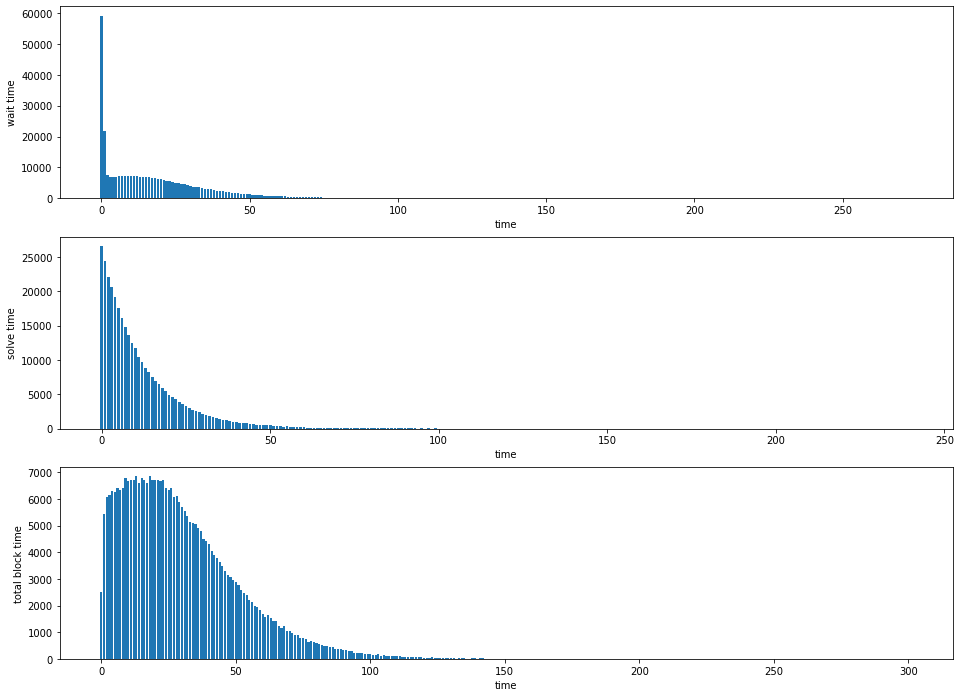

In [557]:
plotHist(hists)